<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-новых-признаков" data-toc-modified-id="Создание-новых-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание новых признаков</a></span></li><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разделение на выборки</a></span></li><li><span><a href="#Модель-RandomForestRegressor" data-toc-modified-id="Модель-RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель RandomForestRegressor</a></span></li><li><span><a href="#Модель-LGBMRegressor" data-toc-modified-id="Модель-LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель LGBMRegressor</a></span></li><li><span><a href="#Модель-Ridge" data-toc-modified-id="Модель-Ridge-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Модель Ridge</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Модель-Ridge" data-toc-modified-id="Модель-Ridge-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Модель Ridge</a></span></li><li><span><a href="#Модель-RandomForestRegressor" data-toc-modified-id="Модель-RandomForestRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Модель RandomForestRegressor</a></span></li><li><span><a href="#Модель-LGBMRegressor" data-toc-modified-id="Модель-LGBMRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Модель LGBMRegressor</a></span></li><li><span><a href="#Проверка-адекватности" data-toc-modified-id="Проверка-адекватности-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Проверка адекватности</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    TimeSeriesSplit
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor

In [2]:

try:
    df = pd.read_csv('/datasets/taxi.csv',sep=',', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/content/taxi.csv', sep=',', index_col=[0], parse_dates=[0])

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверка данных на монотонность

In [4]:
df=df.sort_index()
print(df.index.is_monotonic)

True


<ipython-input-4-7bc2bccd4db7>:2: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  print(df.index.is_monotonic)


Порядок соблюден

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Произведем ресемплирование по одному часу

In [6]:
df = df.resample('1H').sum()
display(df.head())
df.info()
df_week = df.copy()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

Т.к. мы произвели ресемплирование по одному часу, теперь посмотрим на количество заказов в разрезе недели скользящим средним

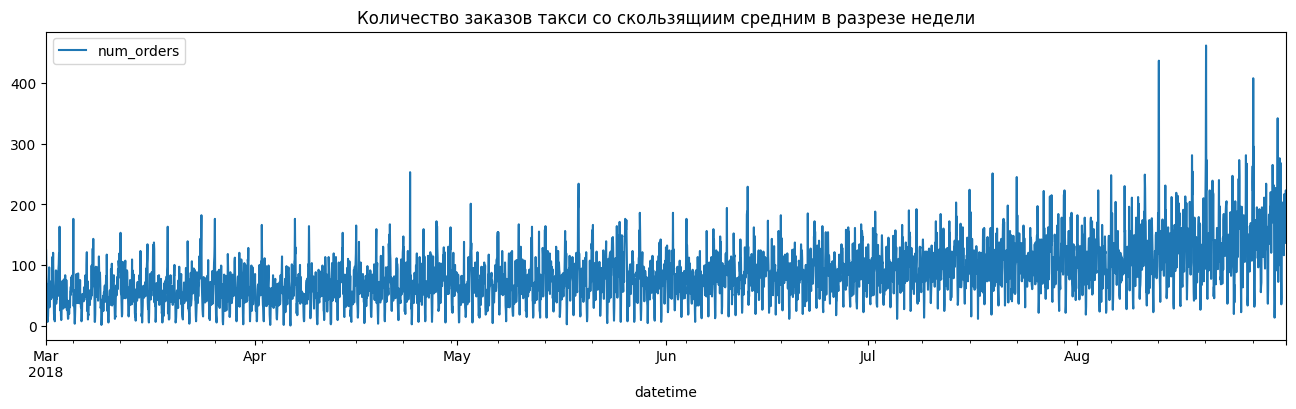

In [7]:
rolling_mean  = df.rolling(24*7).mean()
plt.figure(figsize=(16,4))
plt.title("Количество заказов такси со скользящиим средним в разрезе недели")
df.plot(ax=plt.gca());

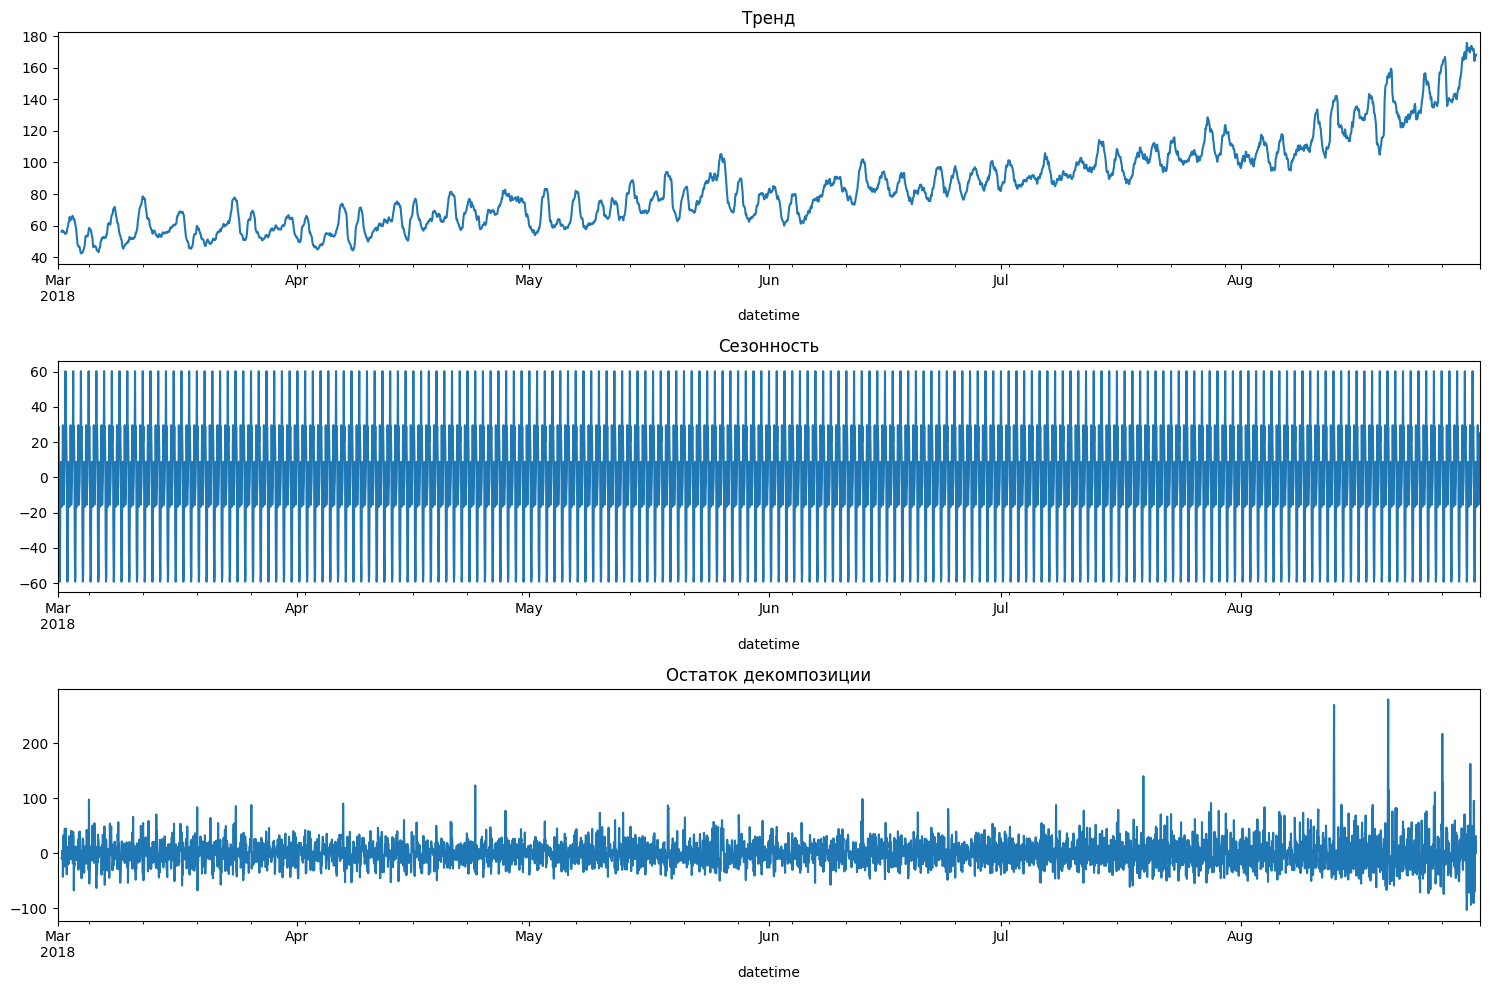

In [8]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции')
plt.tight_layout()

График тренда показал возрастающую зависимость.

Рассматривая график "остатков" декомпозиции, можно сделать вывод о том, что «остатков» к концу графика больше, значит в тестовую выборку попадет чуть больше данных, которые сложно объяснить.

Рассмотрим график сезонности более детально, т.к. по данному графику сезонности сложно сделать выводы. Посмотрим его детальнее.

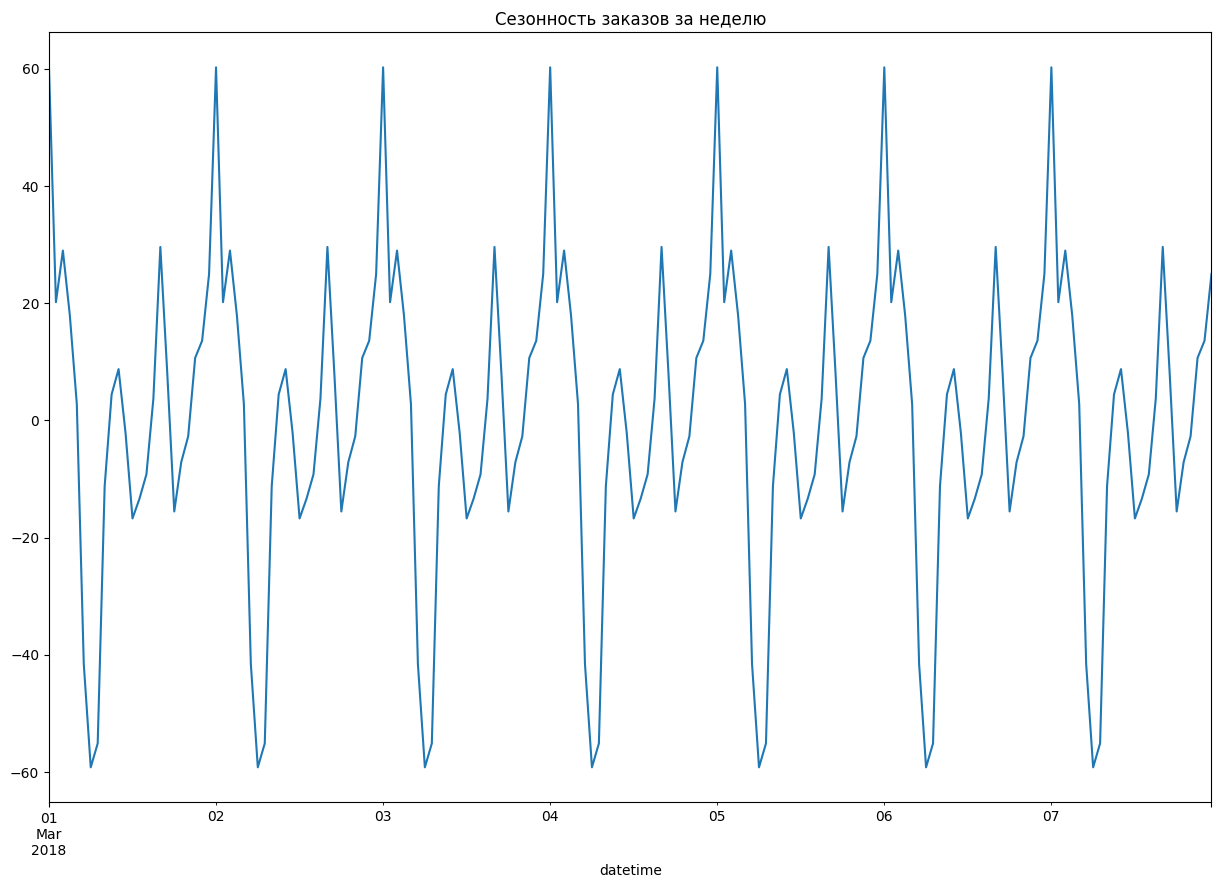

In [9]:
plt.figure(figsize=(15,10))
plt.title('Сезонность заказов за неделю')
decomposed.seasonal['2018-03-01':'2018-03-7'].plot(ax=plt.gca());

Сезонность проявляется в ежедневном повторении заказов. Рассмотрим сезонность в течение двух дней.

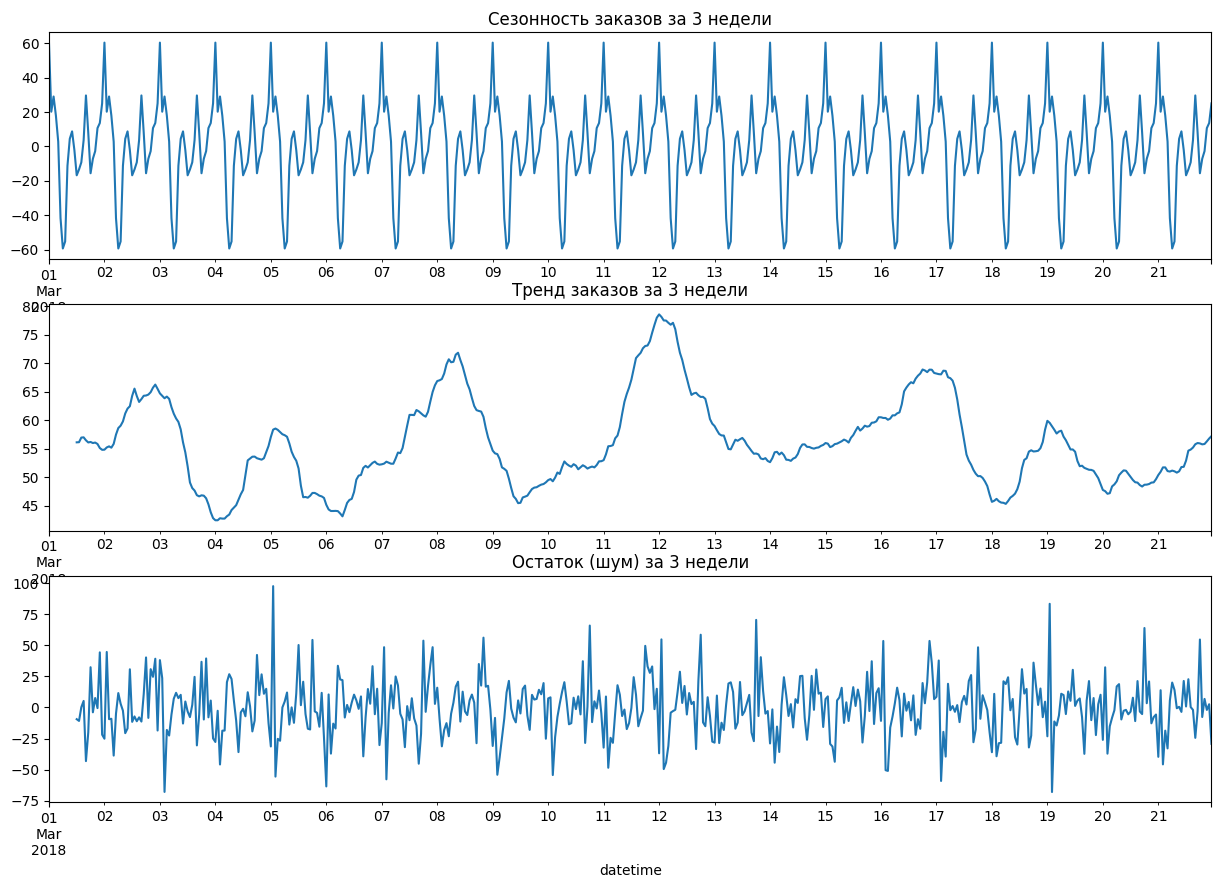

In [10]:
decomposed_week = seasonal_decompose(df_week)
plt.figure(figsize=(15,10))
plt.subplot(311)
plt.title('Сезонность заказов за 3 недели')
decomposed_week.seasonal['2018-03-01':'2018-03-21'].plot(ax=plt.gca());


plt.subplot(312)
plt.title('Тренд заказов за 3 недели')
decomposed_week.trend['2018-03-01':'2018-03-21'].plot(ax=plt.gca());

plt.subplot(313)
plt.title('Остаток (шум) за 3 недели')
decomposed_week.resid['2018-03-01':'2018-03-21'].plot(ax=plt.gca());

Рассмтривая графики, можно сделать вывод о том, что каждую неделю наблюдается определнная закономерность. Значит есть смысл в качестве признака задать "dayofweek".

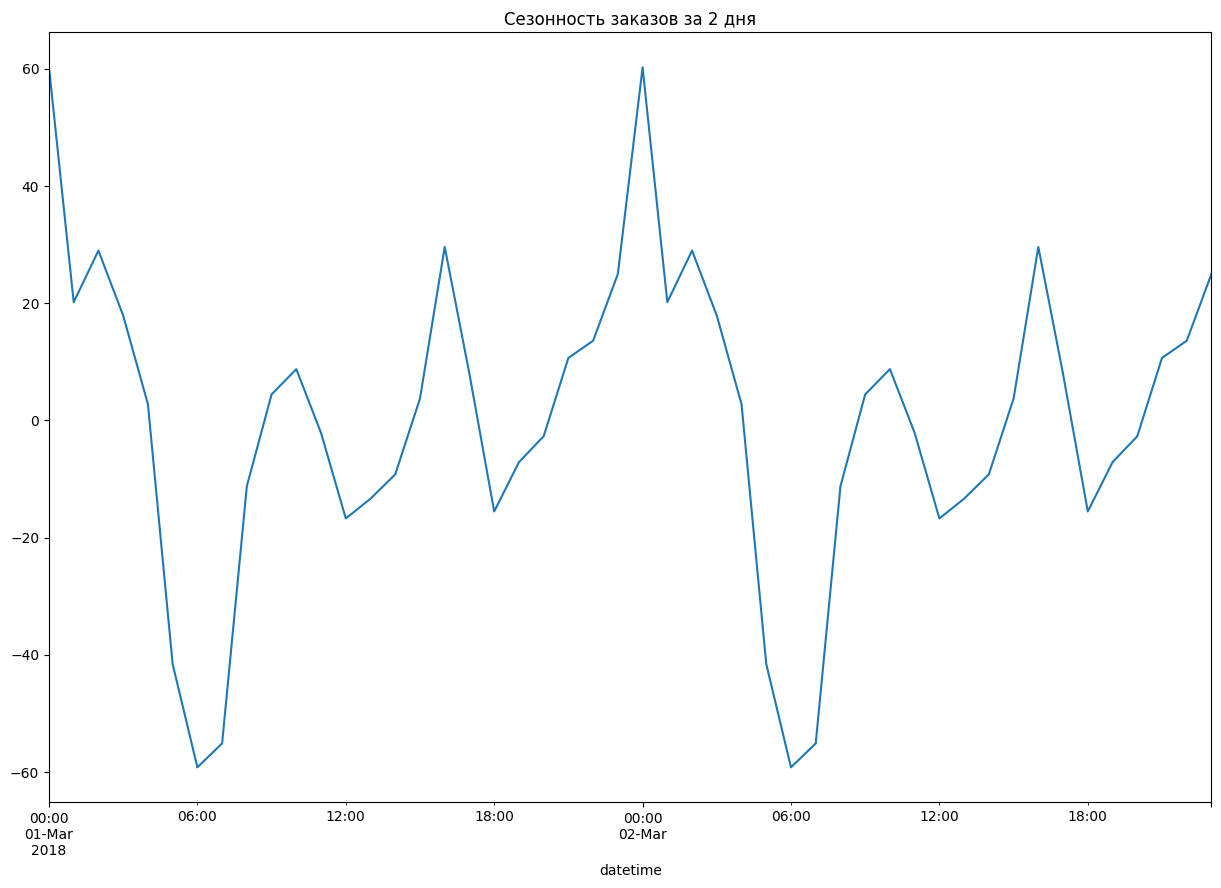

In [11]:
plt.figure(figsize=(15,10))
plt.title('Сезонность заказов за 2 дня')
decomposed.seasonal['2018-03-01':'2018-03-2'].plot(ax=plt.gca());

**Вывод:** Можно сделать вывод о том, что полночь наблюдается пик заказов, а с течением времени снижается и самый минимум достигается в 6:00, а после постепенно возрастает, но также наблюдаются всплески (10:00-11:00, а также 16:00-17:00) и падения (12:00 и 18:00). Также, можно сделать вывод о том, что с течением времени наблюдается тенденция увеличения заказов.
Также, рассмтаривая графики за 3  недели, можно сделать вывод о том, что каждую неделю наблюдается определнная закономерность (т.е. наблюдается недельная сезонность).
Также стоит отметить, что к концу временного ряда доля "остатков" декомпозиции увеличивается, значит в тестовую выборку попадет чуть больше данных, которые сложно объяснить.

## Обучение

### Создание новых признаков

Создадим следующие признаки:

- календарные признаки (час, день недели);
- отстающие значения (предыдущие значения временного ряда покажут, будет ли расти ф-ия x(t) расти или уменьшаться);
- скользящее среднее (задаст общий тренд временного ряда).

In [12]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    return data

In [13]:
df_new = make_features(df, 24, 7)

In [14]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   hour          4416 non-null   int64  
 2   dayofweek     4416 non-null   int64  
 3   rolling_mean  4409 non-null   float64
 4   lag_1         4415 non-null   float64
 5   lag_2         4414 non-null   float64
 6   lag_3         4413 non-null   float64
 7   lag_4         4412 non-null   float64
 8   lag_5         4411 non-null   float64
 9   lag_6         4410 non-null   float64
 10  lag_7         4409 non-null   float64
 11  lag_8         4408 non-null   float64
 12  lag_9         4407 non-null   float64
 13  lag_10        4406 non-null   float64
 14  lag_11        4405 non-null   float64
 15  lag_12        4404 non-null   float64
 16  lag_13        4403 non-null   float64
 17  lag_14        4402 non-null

### Разделение на выборки

Разделим выборки и убедимся в корректности деления выборок на обучающую и тестовую, для этого
выведем максимальные и минимальные зачения индексов выборок.

In [15]:
train, test = train_test_split(df_new, shuffle=False, test_size=0.1)
train = train.dropna()
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Разделение произведено корректно. Выделим в выборках целевой признак.

In [16]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [17]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(3950, 27)
(3950,)
(442, 27)
(442,)


Зафиксируем random_state

In [18]:
RANDOM_STATE = 12345

Чтобы исключить при кросс-вандации, что тренировочная выборка была позже валидационной, то будем применять TimeSeriesSplit. Объект данного типа будем передавать в параметр CV при использовнии GridSearchCV и RandomizedSearchCV.

In [19]:
tscv = TimeSeriesSplit(n_splits=8)

Обучим линейную, «деревянные» и бустингово типа модели с учетом новых признаков.

### Модель RandomForestRegressor

In [20]:
rfr_space={'max_depth': range(4, 40, 2),
          'n_estimators':range(10, 250, 30),
          'min_samples_leaf':range(1,5),
          'min_samples_split':range(2, 10, 2)
          }

rfr = RandomForestRegressor(random_state=RANDOM_STATE)
rfr_random = RandomizedSearchCV(rfr,
                                rfr_space,
                                n_iter=5,
                                scoring='neg_root_mean_squared_error',
                                cv=tscv,
                                error_score='raise',
                                verbose=3)

model_rfr = rfr_random.fit(features_train, target_train)

RMSE_rfr = model_rfr.best_score_*-1


print('Лучшие гиперпараметры rfr: '+str(model_rfr.best_params_))

print('Best RMSE_rfr:', RMSE_rfr)

Fitting 8 folds for each of 5 candidates, totalling 40 fits
[CV 1/8] END max_depth=28, min_samples_leaf=4, min_samples_split=4, n_estimators=130;, score=-19.908 total time=   0.7s
[CV 2/8] END max_depth=28, min_samples_leaf=4, min_samples_split=4, n_estimators=130;, score=-22.399 total time=   1.4s
[CV 3/8] END max_depth=28, min_samples_leaf=4, min_samples_split=4, n_estimators=130;, score=-21.352 total time=   2.2s
[CV 4/8] END max_depth=28, min_samples_leaf=4, min_samples_split=4, n_estimators=130;, score=-23.382 total time=   3.7s
[CV 5/8] END max_depth=28, min_samples_leaf=4, min_samples_split=4, n_estimators=130;, score=-23.367 total time=   3.6s
[CV 6/8] END max_depth=28, min_samples_leaf=4, min_samples_split=4, n_estimators=130;, score=-24.349 total time=   4.3s
[CV 7/8] END max_depth=28, min_samples_leaf=4, min_samples_split=4, n_estimators=130;, score=-28.793 total time=   5.9s
[CV 8/8] END max_depth=28, min_samples_leaf=4, min_samples_split=4, n_estimators=130;, score=-32.287

### Модель LGBMRegressor

In [21]:
lgbmr_space={'num_leaves':[25, 50, 100, 200],
             'learning_rate':[.1, .3, .5]
          }

lgbmr = LGBMRegressor(random_state=RANDOM_STATE)

lgbmr_random = RandomizedSearchCV(lgbmr,
                                lgbmr_space,
                                scoring='neg_root_mean_squared_error',
                                cv=tscv,
                                error_score='raise',
                                verbose=3,
                                n_iter=5
                                 )


model_lgbmr = lgbmr_random.fit(features_train , target_train)

RMSE_lgbmr = model_lgbmr.best_score_ * -1


print('Лучшие гиперпараметры lgbmr: '+str(model_lgbmr.best_params_))

print('RMSE_lgbmr:', RMSE_lgbmr)

Fitting 8 folds for each of 5 candidates, totalling 40 fits
[CV 1/8] END learning_rate=0.5, num_leaves=200;, score=-22.479 total time=   0.1s
[CV 2/8] END learning_rate=0.5, num_leaves=200;, score=-24.405 total time=   0.2s
[CV 3/8] END learning_rate=0.5, num_leaves=200;, score=-23.630 total time=   0.2s
[CV 4/8] END learning_rate=0.5, num_leaves=200;, score=-25.406 total time=   0.3s
[CV 5/8] END learning_rate=0.5, num_leaves=200;, score=-25.479 total time=   0.4s
[CV 6/8] END learning_rate=0.5, num_leaves=200;, score=-26.838 total time=   1.1s
[CV 7/8] END learning_rate=0.5, num_leaves=200;, score=-30.659 total time=   1.2s
[CV 8/8] END learning_rate=0.5, num_leaves=200;, score=-34.786 total time=   1.3s
[CV 1/8] END learning_rate=0.5, num_leaves=25;, score=-22.479 total time=   0.1s
[CV 2/8] END learning_rate=0.5, num_leaves=25;, score=-24.358 total time=   0.1s
[CV 3/8] END learning_rate=0.5, num_leaves=25;, score=-24.852 total time=   0.1s
[CV 4/8] END learning_rate=0.5, num_leave

### Модель Ridge

In [24]:
model_ridge = Ridge(random_state=RANDOM_STATE)


param_grid_ridge = {
    'alpha': np.arange(0, 0.21, 0.01),
}

gs_ridge = GridSearchCV(
    model_ridge,
    cv=tscv,
    param_grid=param_grid_ridge,
    scoring='neg_root_mean_squared_error',
    verbose=3
)


gs_ridge.fit(features_train, target_train)


print(f'Best гиперпараметры model_ridge:{gs_ridge.best_params_} ')


print(f'Best RMSE_ridge: {gs_ridge.best_score_ * -1}')

Fitting 8 folds for each of 21 candidates, totalling 168 fits
[CV 1/8] END .......................alpha=0.0;, score=-22.362 total time=   0.0s
[CV 2/8] END .......................alpha=0.0;, score=-24.211 total time=   0.0s
[CV 3/8] END .......................alpha=0.0;, score=-23.871 total time=   0.0s
[CV 4/8] END .......................alpha=0.0;, score=-25.543 total time=   0.0s
[CV 5/8] END .......................alpha=0.0;, score=-25.136 total time=   0.0s
[CV 6/8] END .......................alpha=0.0;, score=-26.676 total time=   0.0s
[CV 7/8] END .......................alpha=0.0;, score=-30.767 total time=   0.0s
[CV 8/8] END .......................alpha=0.0;, score=-34.356 total time=   0.0s
[CV 1/8] END ......................alpha=0.01;, score=-22.405 total time=   0.0s
[CV 2/8] END ......................alpha=0.01;, score=-24.224 total time=   0.0s
[CV 3/8] END ......................alpha=0.01;, score=-23.875 total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.91359e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.52645e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.08384e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.64038e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


[CV 4/8] END ......................alpha=0.01;, score=-25.543 total time=   0.0s
[CV 5/8] END ......................alpha=0.01;, score=-25.136 total time=   0.0s
[CV 6/8] END ......................alpha=0.01;, score=-26.676 total time=   0.0s
[CV 7/8] END ......................alpha=0.01;, score=-30.767 total time=   0.0s
[CV 8/8] END ......................alpha=0.01;, score=-34.356 total time=   0.0s
[CV 1/8] END ......................alpha=0.02;, score=-22.405 total time=   0.0s
[CV 2/8] END ......................alpha=0.02;, score=-24.224 total time=   0.0s
[CV 3/8] END ......................alpha=0.02;, score=-23.875 total time=   0.0s
[CV 4/8] END ......................alpha=0.02;, score=-25.543 total time=   0.0s
[CV 5/8] END ......................alpha=0.02;, score=-25.136 total time=   0.0s
[CV 6/8] END ......................alpha=0.02;, score=-26.676 total time=   0.0s
[CV 7/8] END ......................alpha=0.02;, score=-30.767 total time=   0.0s
[CV 8/8] END ...............

Все модели показали достаточно хороший результат значения метрики, а время обучения достаточно разное.
Теперь проверим модели на тестовой выборке, возможно на тестовой выборкекакая_то модель покажет результат хуже.

## Тестирование

### Модель Ridge

In [25]:
ridge_prediction = gs_ridge.predict(features_test)
metric_test_ridge = mean_squared_error(target_test, ridge_prediction, squared=False)
metric_test_ridge

45.16327255628265

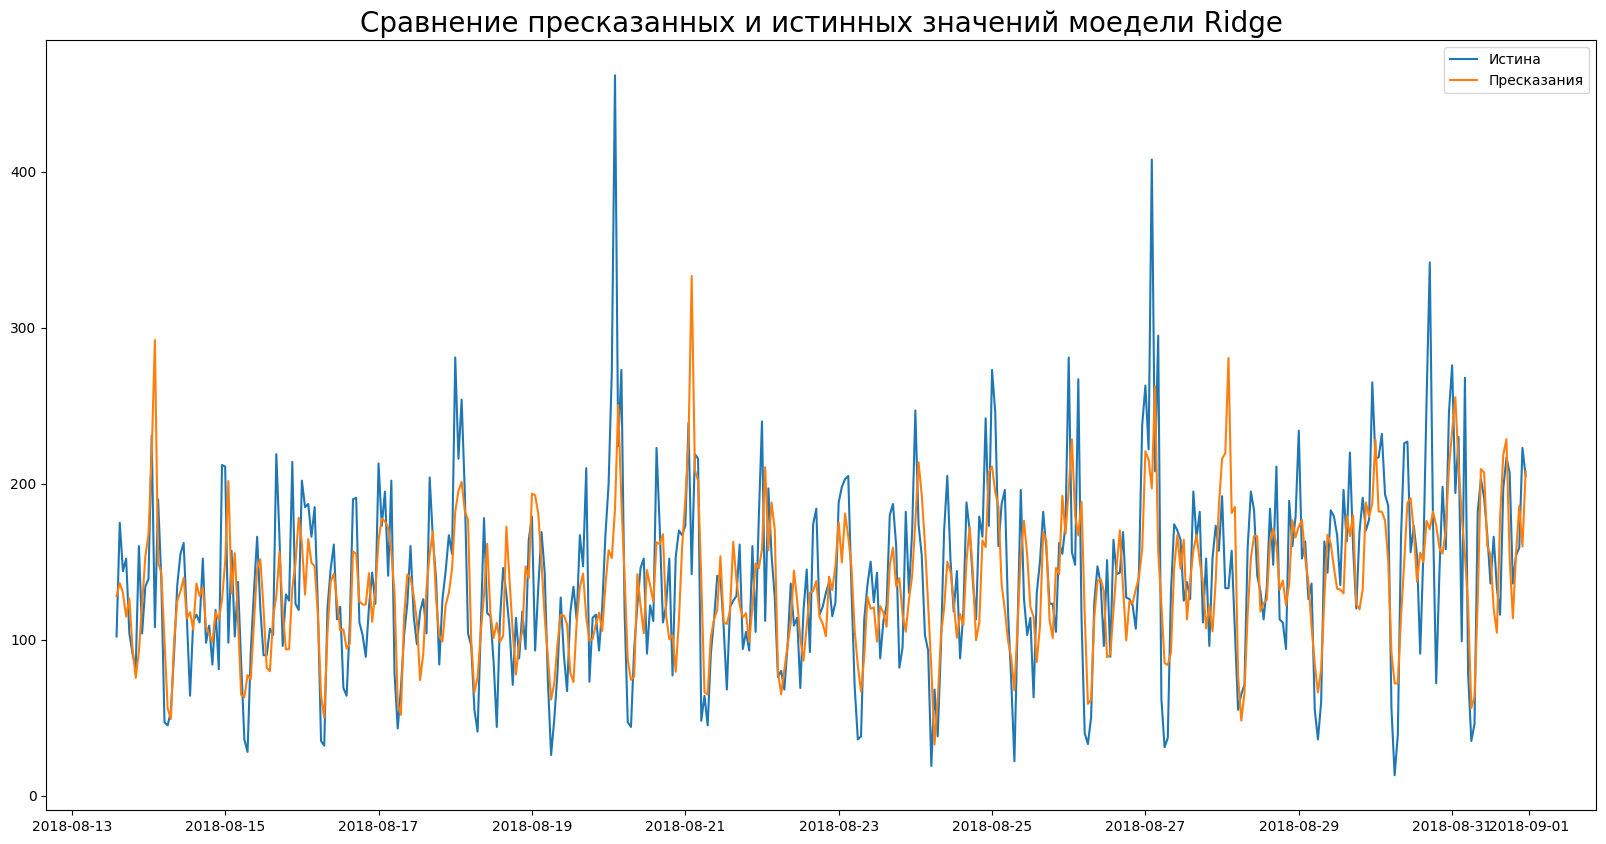

In [26]:
plt.figure(figsize=(20,10))

plt.plot(target_test, label='Истина')
plt.plot(target_test.index, ridge_prediction, label='Пресказания')

plt.title('Сравнение пресказанных и истинных значений моедели Ridge',fontsize=20)
plt.legend();

### Модель RandomForestRegressor

In [27]:
rfr_prediction = rfr_random.predict(features_test)
metric_test_rfr = mean_squared_error(target_test, rfr_prediction, squared=False)
metric_test_rfr

41.638006754330526

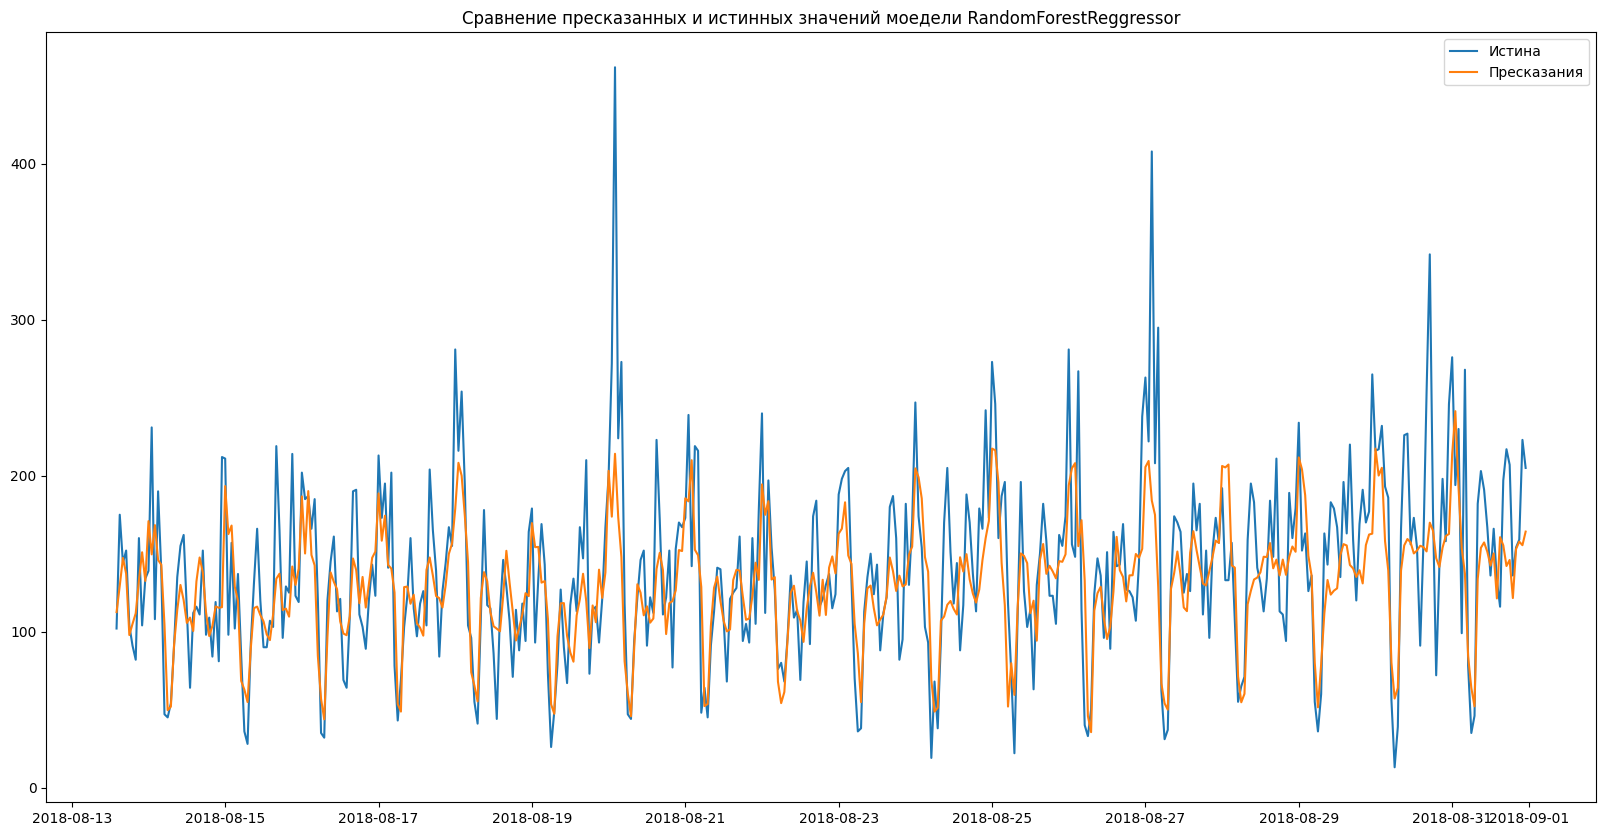

In [28]:
plt.figure(figsize=(20,10))

plt.plot(target_test, label='Истина')
plt.plot(target_test.index, rfr_prediction, label='Пресказания')

plt.title('Сравнение пресказанных и истинных значений моедели RandomForestReggressor')
plt.legend();

### Модель LGBMRegressor

In [29]:
lgbmr_prediction = lgbmr_random.predict(features_test)
metric_test_lgbmr = mean_squared_error(target_test, lgbmr_prediction, squared=False)
metric_test_lgbmr

41.095900597562526

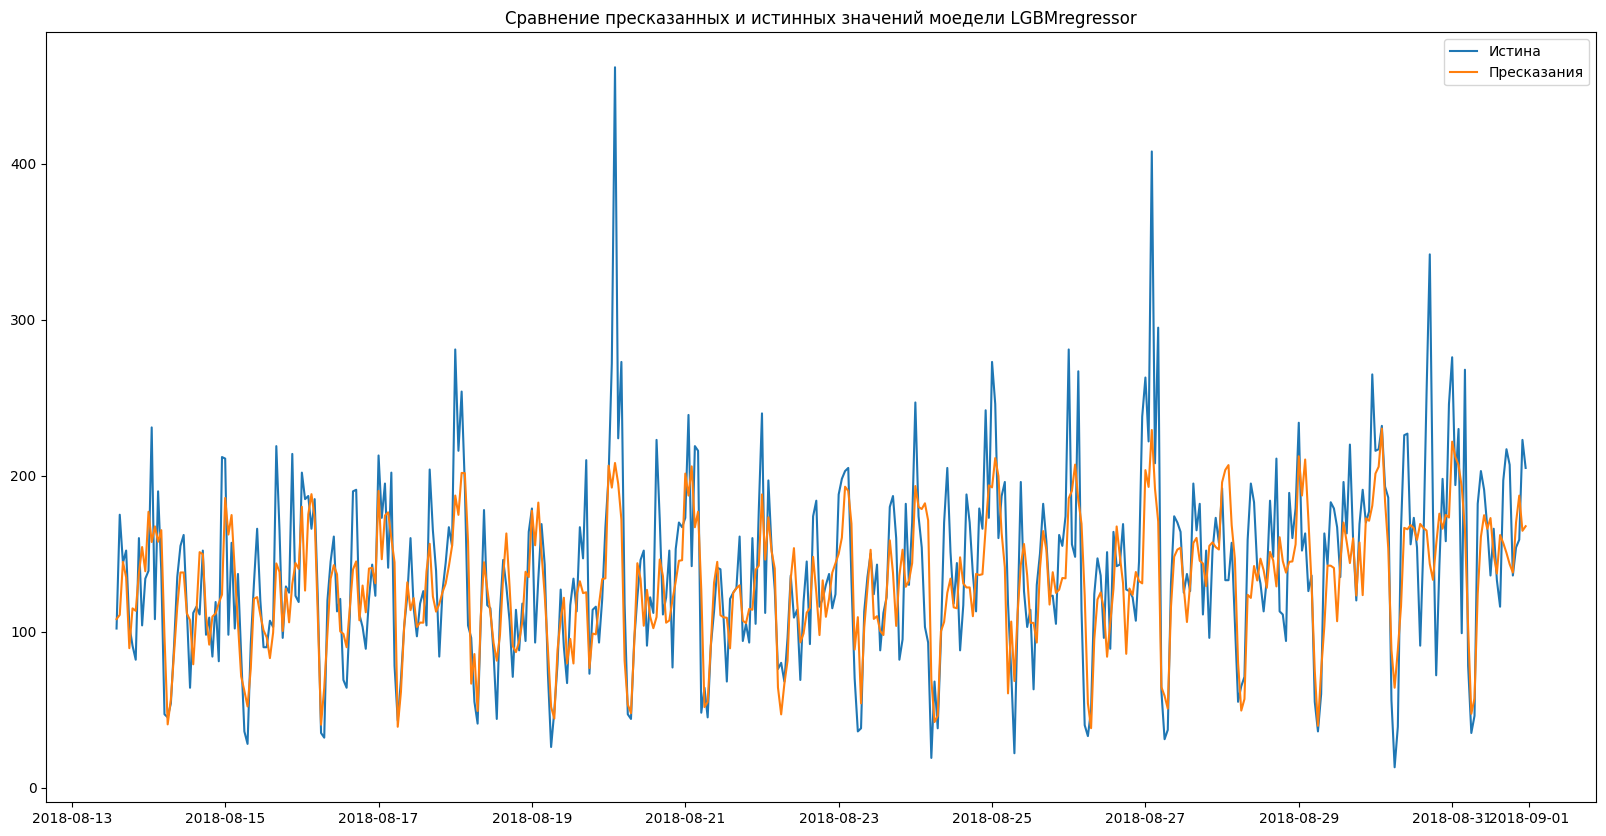

In [30]:
plt.figure(figsize=(20,10))

plt.plot(target_test, label='Истина')
plt.plot(target_test.index, lgbmr_prediction, label='Пресказания')

plt.title('Сравнение пресказанных и истинных значений моедели LGBMregressor')
plt.legend();

### Проверка адекватности

In [31]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
print("RMSE:", mean_squared_error(target_test, pred_previous))

RMSE: 3464.085972850679


**Вывод:** При выполнении проекта выполнены следующие этапы:
1) Произведено ресемплировие данных по одному часу;

2) Проанализированы данные, где определены основные тренды и сезонность (см. раздел 2);

3) Обучены различные модели на тренировочной выборке с подбором различных гиперпараметров при использовании кросс-валидации;

4) Произведено тестировах коделей, где наилучшие результаты показала LGBMRegressor, удовлетворяющая требования по значению метрики RMSE < 48.

5) Проведена проверка адекватностей моделей.

Если рассматривать совокупность факторов (скорость и значение RMSE), то рекомендована модель RandomForestRegressor.

Если рассматривать только значение RMSE, то рекомендована LGBMRegressor.